# Imports

In [1]:
import gc
from operator import concat
import kagglehub
import kagglehub.config
import json
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pytorch_lightning as pl
import torch
import torch.nn as nn
import torchmetrics
from sentry_sdk.utils import epoch
from torch.xpu import device
from torchmetrics.functional import precision

import wandb
import pytorch_lightning.loggers as wandb_logger
from torchvision.models.segmentation import fcn_resnet50, deeplabv3_resnet50
from RoadDataLoader import RoadDataLoader

c:\Python3.12\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Download

In [2]:
# get kaggle credentials file from ./kaggle.json
with open("./kaggle.json", "r") as f:
    kaggle_json = json.load(f)
kaggel_username = kaggle_json["username"]
kaggel_key = kaggle_json["key"]

In [3]:
kagglehub.config.set_kaggle_credentials(kaggel_username, kaggel_key)

Kaggle credentials set.


In [4]:
# Download latest version
path = kagglehub.dataset_download("payne18/road-detection-dataset-with-masks")
# make data folder if it does not exist
if not os.path.exists("./data"):
    os.mkdir("./data")
# Move data folder to ./data
os.system(f"mv {path} ./data/road-detection-dataset-with-masks")
# remove empty folder
folder_to_remove = path.split("payne18/road-detection-dataset-with-masks")[0] 
os.system((f"rm -r {folder_to_remove}"))

1

# Lightning module

In [5]:
def dice_score(pred, target, smooth=1e-4):
    pred = torch.sigmoid(pred)
    intersection = (pred * target).sum()
    union = pred.sum() + target.sum()
    dice = (2 * intersection + smooth) / (union + smooth)
    return dice

def iou_score(pred, target, smooth=1e-4):
    pred = torch.sigmoid(pred)
    intersection = (pred * target).sum()
    union = pred.sum() + target.sum() - intersection
    iou = (intersection + smooth) / (union + smooth)
    return iou


In [6]:
class RoadSegmentationModule(pl.LightningModule):
    def __init__(self, model, loss_fn, optimizer, only_last_layer=False, weight_decay=0.01, lr=1e-3):
        super().__init__()
        self.model = model
        self.loss_fn = loss_fn
        self.precision_fn = torchmetrics.Precision(task="binary")
        self.optimizer = optimizer
        self.lr = lr
        self.only_last_layer = only_last_layer
        self.weight_decay = weight_decay
        
    def forward(self, x):
        return self.model(x)
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        pred = self(x)
        if y.shape != pred.shape:
            pred = pred.squeeze(1)
        loss = self.loss_fn(pred, y)
        precision = self.precision_fn(pred, y)
        dice = dice_score(pred, y)
        iou = iou_score(pred, y)
        
        self.log("train_loss", loss, prog_bar=True, on_step=True, on_epoch=True)
        self.log("train_precision", precision, prog_bar=True, on_step=True, on_epoch=True)
        self.log("train_dice", dice, prog_bar=True, on_step=True, on_epoch=True)
        self.log("train_iou", iou, prog_bar=True, on_step=True, on_epoch=True)
        
        return loss
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        pred = self(x)
        if y.shape != pred.shape:
            pred = pred.squeeze(1)
        loss = self.loss_fn(pred, y)
        precision = self.precision_fn(pred, y)
        dice = dice_score(pred, y)
        iou = iou_score(pred, y)
        
        self.log("val_loss", loss, prog_bar=True, on_step=True, on_epoch=True)
        self.log("val_precision", precision, prog_bar=True, on_step=True, on_epoch=True)
        self.log("val_dice", dice, prog_bar=True, on_step=True, on_epoch=True)
        self.log("val_iou", iou, prog_bar=True, on_step=True, on_epoch=True)
        
        return loss
    
    def configure_optimizers(self):
        if self.optimizer == "Adam":
            if self.only_last_layer:
                opt = torch.optim.Adam(filter(lambda p: p.requires_grad, self.model.parameters()), lr=self.lr)
            else:
                opt = torch.optim.Adam(self.model.parameters(), lr=self.lr)
        elif self.optimizer == "AdamW":
            if self.only_last_layer:
                opt = torch.optim.AdamW(filter(lambda p: p.requires_grad, self.model.parameters()), lr=self.lr, weight_decay=self.weight_decay)
            else:
                opt = torch.optim.AdamW(self.model.parameters(), lr=self.lr, weight_decay=self.weight_decay)
        else:
            raise ValueError("Optimizer not implemented in RoadSegmentationModule")
        return opt


# Vision Transformers model

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class PatchEmbedding(nn.Module):
    def __init__(self, in_channels, embed_dim, patch_size):
        super().__init__()
        self.patch_size = patch_size
        self.proj = nn.Conv2d(in_channels, embed_dim, kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        x = self.proj(x)  # [B, embed_dim, H//patch_size, W//patch_size]
        x = x.flatten(2).transpose(1, 2)  # [B, N_patches, embed_dim]
        return x

class TransformerBlock(nn.Module):
    def __init__(self, embed_dim, num_heads, mlp_ratio=4.0, dropout=0.1):
        super().__init__()
        self.attn = nn.MultiheadAttention(embed_dim, num_heads, dropout=dropout)
        self.mlp = nn.Sequential(
            nn.Linear(embed_dim, int(embed_dim * mlp_ratio)),
            nn.GELU(),
            nn.Linear(int(embed_dim * mlp_ratio), embed_dim),
            nn.Dropout(dropout),
        )
        self.norm1 = nn.LayerNorm(embed_dim)
        self.norm2 = nn.LayerNorm(embed_dim)

    def forward(self, x):
        x = x + self.attn(self.norm1(x), self.norm1(x), self.norm1(x))[0]
        x = x + self.mlp(self.norm2(x))
        return x

class TransformerEncoder(nn.Module):
    def __init__(self, embed_dim, num_heads, depth, mlp_ratio=4.0, dropout=0.1):
        super().__init__()
        self.blocks = nn.ModuleList([
            TransformerBlock(embed_dim, num_heads, mlp_ratio, dropout) for _ in range(depth)
        ])

    def forward(self, x):
        for block in self.blocks:
            x = block(x)
        return x

class SegmentationHead(nn.Module):
    def __init__(self, embed_dim, num_classes, patch_size, img_size):
        super().__init__()
        self.img_size = img_size
        self.patch_size = patch_size
        self.num_classes = num_classes
        self.head = nn.Linear(embed_dim, num_classes)

    def forward(self, x):
        H, W = self.img_size // self.patch_size, self.img_size // self.patch_size
        x = self.head(x)  # [B, N_patches, num_classes]
        x = x.transpose(1, 2).reshape(-1, H, W, self.num_classes).permute(0, 3, 1, 2)  # [B, num_classes, H, W]
        x = F.interpolate(x, size=(self.img_size, self.img_size), mode='bilinear', align_corners=False)
        return x

class TransformerSegmenter(nn.Module):
    def __init__(self, in_channels, num_classes, img_size, patch_size, embed_dim, num_heads, depth):
        super().__init__()
        self.patch_embed = PatchEmbedding(in_channels, embed_dim, patch_size)
        self.encoder = TransformerEncoder(embed_dim, num_heads, depth)
        self.seg_head = SegmentationHead(embed_dim, num_classes, patch_size, img_size)

    def forward(self, x):
        x = self.patch_embed(x)
        x = self.encoder(x)
        x = self.seg_head(x)
        return x

# Load Data

In [8]:
data_path = "./data/road-detection-dataset-with-masks/deepglobe-road-extraction-dataset"
metadata_path = "./data/road-detection-dataset-with-masks/deepglobe-road-extraction-dataset/metadata.csv"

In [9]:
# open metadata
metadata = pd.read_csv(metadata_path)
print(f"All data: {metadata.shape[0]}")

All data: 8570


In [10]:
metadata = metadata[metadata["split"] == "train"]
print(f"Data without validation and test: {metadata.shape[0]}")
metadata["sat_image_path"] = metadata["sat_image_path"].apply(lambda x: os.path.join(data_path, x))
metadata["mask_path"] = metadata["mask_path"].apply(lambda x: os.path.join(data_path, x))
metadata.head()

Data without validation and test: 6226


,image_id,split,sat_image_path,mask_path
0,100034,train,./data/road-detection-dataset-with-masks/deepg...,./data/road-detection-dataset-with-masks/deepg...
1,100081,train,./data/road-detection-dataset-with-masks/deepg...,./data/road-detection-dataset-with-masks/deepg...
2,100129,train,./data/road-detection-dataset-with-masks/deepg...,./data/road-detection-dataset-with-masks/deepg...
3,100703,train,./data/road-detection-dataset-with-masks/deepg...,./data/road-detection-dataset-with-masks/deepg...
4,100712,train,./data/road-detection-dataset-with-masks/deepg...,./data/road-detection-dataset-with-masks/deepg...


# Training

In [11]:
def dice_loss(pred, target, smooth=1e-4):
    pred = torch.sigmoid(pred)
    intersection = (pred * target).sum()
    union = pred.sum() + target.sum()
    dice = 1 - (2 * intersection + smooth) / (union + smooth)
    return dice

def combined_loss(pred, target, alpha=0.5):
    bce = nn.BCEWithLogitsLoss()(pred, target)
    dice = dice_loss(pred, target)
    return alpha * bce + (1 - alpha) * dice

In [12]:
# hyperparameters
batch_size = 8
optimizer = "Adam"
lr = 1e-4
weight_decay = 0.01
epochs = 10
loss_fn = combined_loss
accelerator = "auto"
pretrained = False
image_size = 512
num_workers = 8

In [13]:
dataLoader = RoadDataLoader(metadata, batch_size=batch_size, image_size=image_size, num_workers=num_workers)
# dataLoader.setup()
dataLoader.train_data = pd.read_csv("./metadata/traindata.csv", index_col=0)
dataLoader.val_data = pd.read_csv("./metadata/valdata.csv", index_col=0)
dataLoader.test_data = pd.read_csv("./metadata/testdata.csv", index_col=0)
dataLoader.train_data.head()

,image_id,split,sat_image_path,mask_path
2988,524867,train,./data/road-detection-dataset-with-masks/deepg...,./data/road-detection-dataset-with-masks/deepg...
72,110680,train,./data/road-detection-dataset-with-masks/deepg...,./data/road-detection-dataset-with-masks/deepg...
5370,869652,train,./data/road-detection-dataset-with-masks/deepg...,./data/road-detection-dataset-with-masks/deepg...
4394,73033,train,./data/road-detection-dataset-with-masks/deepg...,./data/road-detection-dataset-with-masks/deepg...
2152,40682,train,./data/road-detection-dataset-with-masks/deepg...,./data/road-detection-dataset-with-masks/deepg...


In [14]:
train_data_loader = dataLoader.train_dataloader()
val_data_loader = dataLoader.val_dataloader()

In [15]:
# save dataLoader.traindata, dataLoader.valdata and dataLoader.testdata to csv
# dataLoader.train_data.to_csv("./metadata/traindata.csv")
# dataLoader.val_data.to_csv("./metadata/valdata.csv")
# dataLoader.test_data.to_csv("./metadata/testdata.csv")

# Training with Vision Transformers

In [16]:
#!chmod 777 -r
wandb.login()
model = TransformerSegmenter(in_channels=3, num_classes=1, num_heads=1, img_size=image_size,embed_dim=1, depth=1, patch_size=2)
module = RoadSegmentationModule(model, loss_fn, optimizer)
log = wandb_logger.WandbLogger(project="road-segmentation", log_model="all", name="TransformerSegmenter")
checkpoint_callback = pl.callbacks.ModelCheckpoint(monitor="val_loss", mode="min")

trainer = pl.Trainer(
    max_epochs=epochs,
    accelerator="auto",
    logger=log,
    callbacks=[checkpoint_callback]
)

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: jurasekjonas12. Use `wandb login --relogin` to force relogin
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [17]:
trainer.fit(module, train_data_loader, val_data_loader)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type                 | Params | Mode 
--------------------------------------------------------------
0 | model        | TransformerSegmenter | 40     | train
1 | precision_fn | BinaryPrecision      | 0      | train
--------------------------------------------------------------
40        Trainable params
0         Non-trainable params
40        Total params
0.000     Total estimated model params size (MB)
18        Modules in train mode
0         Modules in eval mode


Epoch 6:   0%|          | 0/561 [00:00<?, ?it/s, v_num=alnm, train_loss_step=0.529, train_precision_step=0.000, train_dice_step=0.0269, train_iou_step=0.0136, val_loss_step=0.530, val_precision_step=0.008, val_dice_step=0.0832, val_iou_step=0.0434, val_loss_epoch=0.554, val_precision_epoch=0.0291, val_dice_epoch=0.0758, val_iou_epoch=0.0395, train_loss_epoch=0.552, train_precision_epoch=0.0326, train_dice_epoch=0.0749, train_iou_epoch=0.039]                


Detected KeyboardInterrupt, attempting graceful shutdown ...


NameError: name 'exit' is not defined

In [18]:
wandb.finish()
visiontransformer_model_path = checkpoint_callback.best_model_path
print(visiontransformer_model_path)

epoch,▁▁▁▁▁▁▂▂▂▂▂▂▄▄▄▄▄▄▄▅▅▅▅▅▅▅▇▇▇▇▇▇▇▇██████
train_dice_epoch,█▁▄▆▇▇
train_dice_step,▃▁▃▃▅▂▂▂▂▂▂▄▂▅▃▃▂▂▄▆▄▄█▆▄▄▄▆▃▂▃▂▃▄▂▄▂▁▄█
train_iou_epoch,█▁▄▆▇▇
train_iou_step,▃▃▃▂▅▂▂▄▂▂▂▂▄▂▃▆▃▃▄▃▄▆▄▅▂▃▆▃▂▃▂▃▇▁▃▅▂▁▄█
train_loss_epoch,█▁▁▁▁▁
train_loss_step,█▅▃▂▂▁▂▂▁▂▂▁▃▂▂▂▂▂▂▁▃▃▂▂▂▃▂▂▂▁▁▂▂▁▂▂▂▂▂▂
train_precision_epoch,▁▄▇██▇
train_precision_step,▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▂█▁▁▁▁▃▁▃▅▁▁▁▁▁▁▂▁▂▃
trainer/global_step,▁▁▁▁▁▄▅▂▂▂▂▇▂▂▂▃▃▃▃▃▃█▃▃▃▄▄▄▄▄▄▄▄▄▄▄▄▄▅▅
val_dice_epoch,▁▃▄▇▇█


.\road-segmentation\khdbalnm\checkpoints\epoch=5-step=3366.ckpt


In [ ]:
# save the best model as VisionTransformer_best_model.cpkt
!cp {visiontransformer_model_path} ./models//VisionTransformer_best_model.cpkt

# Testing models

In [19]:
def show_result(x, y, pred, title, sigmoid=True):
    if sigmoid:
        pred = torch.sigmoid(pred)
    fig, ax = plt.subplots(4, 3, figsize=(15, 25))
    fig.suptitle(title)
    for i in range(4):
        # denormalize x
        image = x[i] * 0.5 + 0.5
        ax[i, 0].imshow(image.permute(1, 2, 0))
        ax[i, 0].set_title("Input")
        ax[i, 0].axis("off")
        ax[i, 1].imshow(y[i].squeeze(0))
        ax[i, 1].set_title("Target")
        ax[i, 1].axis("off")
        ax[i, 2].imshow(pred[i].squeeze(0).detach().numpy())
        ax[i, 2].set_title("Prediction")
        ax[i, 2].axis("off")
    #tight layout
    plt.tight_layout()
    plt.show()

In [20]:
import time

def eval_model(model, dataLoader, device, model_name='model'):
    model.to(device)
    model.eval()
    
    precision = torchmetrics.Precision(task="binary").to(device)
    accuracy = torchmetrics.Accuracy(task='binary').to(device)
    
    total_IoU, total_dice, total_precision, total_accuracy, total_ABD = 0, 0, 0, 0, 0
    num_batches = len(dataLoader)
    
    inference_time = []
    with torch.no_grad():
        for x, y in dataLoader:
            x = x.to(device)
            y = y.to(device)
            
            start = time.time()
            pred = model(x)
            torch.cuda.synchronize()
            end = time.time()
            
            inference_time.append(end - start)
            
            total_IoU += iou_score(pred, y)
            total_dice += dice_score(pred, y)
            
            total_precision += precision(pred, y)
            total_accuracy += accuracy(pred, y)
 
    avg_IoU = total_IoU / num_batches
    avg_dice = total_dice / num_batches
    avg_precision = total_precision / num_batches
    avg_accuracy = total_accuracy / num_batches
    avg_inference_time = sum(inference_time) / len(inference_time)
    
    print(f"{model_name} IoU: {avg_IoU}")
    print(f"{model_name} Dice: {avg_dice}")
    print(f"{model_name} Precision: {avg_precision}")
    print(f"{model_name} Accuracy: {avg_accuracy}")
    print(f"{model_name} Inference time: {avg_inference_time}")
    return avg_IoU, avg_dice, avg_precision, avg_accuracy, avg_inference_time

In [21]:
dataLoader = RoadDataLoader(metadata, batch_size=4, image_size=512, num_workers=8)
dataLoader.train_data = pd.read_csv("./metadata/traindata.csv", index_col=0)
dataLoader.val_data = pd.read_csv("./metadata/valdata.csv", index_col=0)
dataLoader.test_data = pd.read_csv("./metadata/testdata.csv", index_col=0)

In [22]:
test_dataLoader = dataLoader.test_dataloader()

for batch in test_dataLoader:
    x, y = batch
    break


In [ ]:
visiontransformer_model_path = "./models/DeepLabV3_best_model.cpkt"

### Vision Transformer evaluation

In [ ]:
vt_state_dict = torch.load(visiontransformer_model_path)["state_dict"]
print(vt_state_dict)
vt_state_model = TransformerSegmenter(in_channels=3, num_classes=1, num_heads=1, img_size=image_size,embed_dim=1, depth=1, patch_size=8)
vt_state_model.load_state_dict(vt_state_dict, strict=False)
vt_module = RoadSegmentationModule(vt_state_model, combined_loss, optimizer)

OrderedDict({'model.patch_embed.proj.weight': tensor([[[[-0.2573, -0.2495],
          [ 0.0193, -0.4796]],

         [[-0.5643, -0.4498],
          [-0.1873, -0.3488]],

         [[-0.7804, -0.8337],
          [-0.5249, -0.4607]]]], device='cuda:0'), 'model.patch_embed.proj.bias': tensor([0.4068], device='cuda:0'), 'model.encoder.blocks.0.attn.in_proj_weight': tensor([[ 1.0093],
        [ 0.1225],
        [-0.7758]], device='cuda:0'), 'model.encoder.blocks.0.attn.in_proj_bias': tensor([ 6.7973e-07,  1.5977e-05, -3.1320e-01], device='cuda:0'), 'model.encoder.blocks.0.attn.out_proj.weight': tensor([[-1.4203]], device='cuda:0'), 'model.encoder.blocks.0.attn.out_proj.bias': tensor([0.2954], device='cuda:0'), 'model.encoder.blocks.0.mlp.0.weight': tensor([[-0.0629],
        [-0.8207],
        [ 0.4801],
        [-0.6800]], device='cuda:0'), 'model.encoder.blocks.0.mlp.0.bias': tensor([ 0.7154, -0.2877, -0.4591, -0.9668], device='cuda:0'), 'model.encoder.blocks.0.mlp.2.weight': tensor([[-0.1

C:\Users\juras\AppData\Local\Temp\ipykernel_7968\1612560655.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  vt_state_dict = torch.load(visiontransformer_model_path)["sta

In [27]:
device = "cuda" if torch.cuda.is_available() else "cpu"
vt_module.to(device)
x = x.to(device)
y = y.to(device)

vt_module.eval()
pred = vt_module(x)

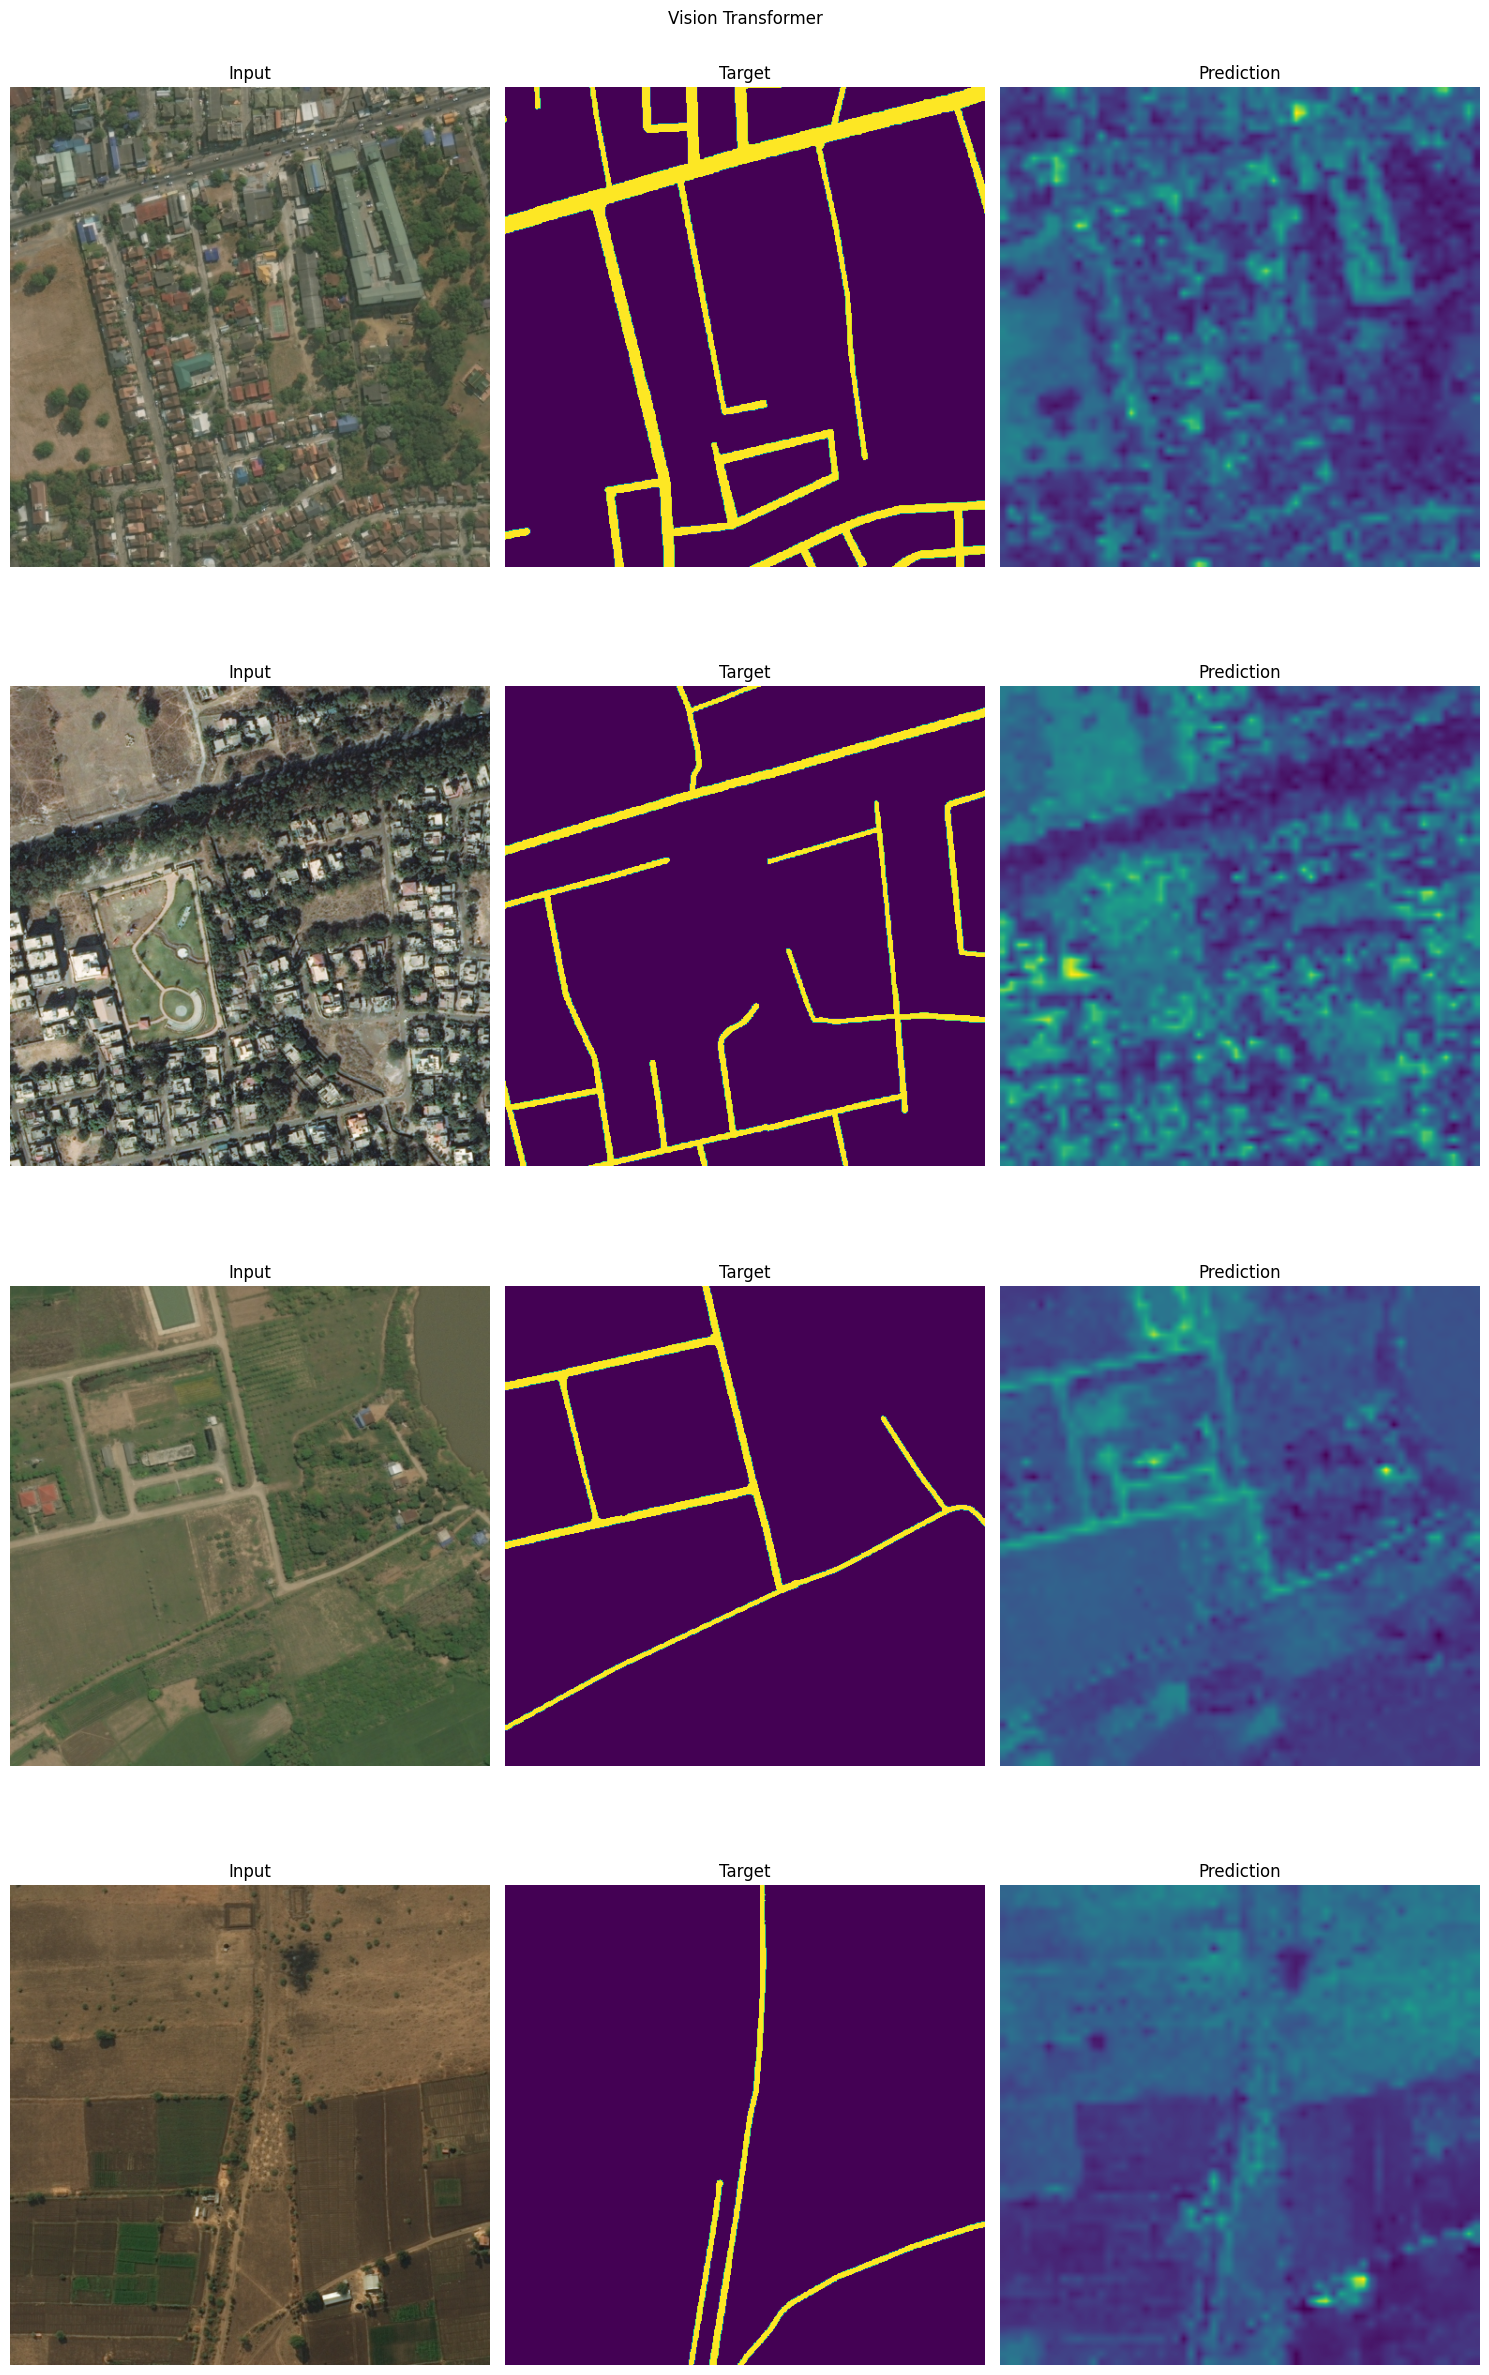

In [28]:
show_result(x.cpu(), y.cpu(), pred.cpu(), "Vision Transformer", sigmoid=True)

In [29]:
test_dataLoader = dataLoader.test_dataloader()
VT_avg_IoU, VT_avg_dice, VT_avg_precision, VT_avg_accuracy, VT_avg_inference_time = eval_model(vt_module, test_dataLoader, device, "Vision Transformer")

Vision Transformer IoU: 0.03924504294991493
Vision Transformer Dice: 0.07501368224620819
Vision Transformer Precision: 0.0
Vision Transformer Accuracy: 0.9570911526679993
Vision Transformer Inference time: 0.030653287887573242


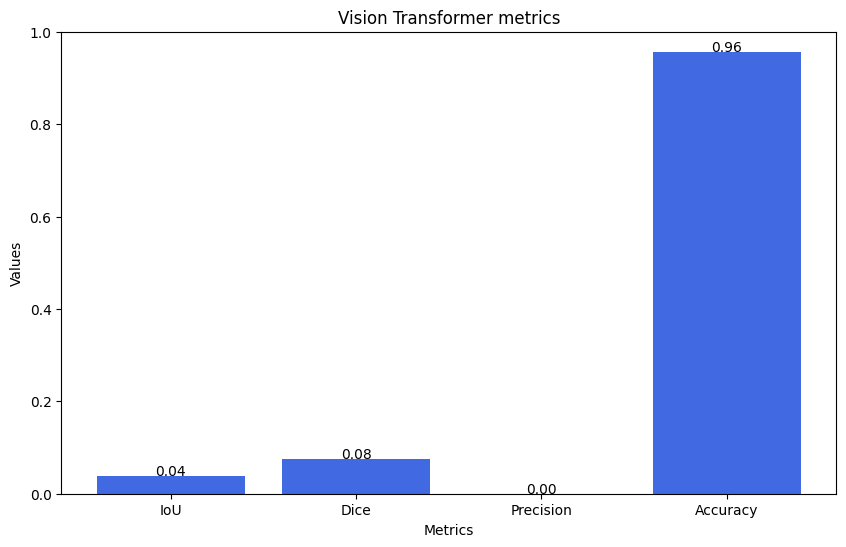

In [ ]:
# show result
metrics = ['IoU', 'Dice', 'Precision', 'Accuracy']
values = [VT_avg_IoU.cpu(), VT_avg_dice.cpu(), VT_avg_precision.cpu(), VT_avg_accuracy.cpu()]

plt.figure(figsize=(10, 6))
plt.bar(metrics, values, color='royalblue')

plt.title('Vision Transformer metrics')
plt.xlabel('Metrics')
plt.ylabel('Values')
plt.ylim(0, 1)

for i, v in enumerate(values):
    plt.text(i, v + 0.01, f'{v:.2f}', ha='center', va='center')
plt.show()